In [1]:
import numpy as np
import os
import sys
import pickle
import pandas as pd
from multiprocessing import Pool
%matplotlib inline
import matplotlib.pyplot as plt

from ekphrasis.classes.preprocessor import TextPreProcessor
from ekphrasis.classes.tokenizer import SocialTokenizer
from ekphrasis.dicts.emoticons import emoticons

from sklearn.model_selection import train_test_split
from keras.constraints import maxnorm
from keras.engine import Input
from keras.engine import Model
from keras.layers import Dropout, Dense, Bidirectional, LSTM, \
    Embedding, GaussianNoise, Activation, Flatten, \
    RepeatVector, MaxoutDense, GlobalMaxPooling1D, \
    Convolution1D, MaxPooling1D, concatenate, Conv1D, GRU, Flatten, MaxPool1D
from keras.models import Sequential
from keras.optimizers import Adam
from keras.regularizers import l2
from kutilities.layers import AttentionWithContext, Attention, MeanOverTime
from kutilities.helpers.data_preparation import print_dataset_statistics, \
labels_to_categories, categories_to_onehot
from sklearn.metrics import f1_score, precision_score
from sklearn.metrics import recall_score
from kutilities.callbacks import MetricsCallback, PlottingCallback
from kutilities.helpers.data_preparation import get_labels_to_categories_map, \
get_class_weights2, onehot_to_categories
from keras.callbacks import ModelCheckpoint
import scipy.stats
import keras
from keras.utils import np_utils, to_categorical
from keras.models import load_model
from keras.utils import CustomObjectScope, plot_model

from sklearn.model_selection import StratifiedKFold

from collections import defaultdict

Using TensorFlow backend.
/home/arthur/anaconda3/envs/dlnlp/lib/python3.6/site-packages/kutilities/callbacks.py:6: UserWarning: matplotlib.pyplot as already been imported, this call will have no effect.
  matplotlib.use('TkAgg')


- Loading wor2vec and buid embeddings if not in data folder

In [2]:
tmp_file = '../data/datastories.twitter.100d'
embedding_file = tmp_file + '.txt'
pickle_file = tmp_file + '.pickle'
embedding_dim = 100

if os.path.exists(pickle_file):
    with open(pickle_file, 'rb') as f:
        wv_data = pickle.load(f)
elif os.path.exists(embedding_file):
    print('Indexing file {} ...'.format(embedding_file))
    wv_data = {}
    with open(embedding_file, "r", encoding="utf-8") as f:
        for i, line in enumerate(f):
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')

            wv_data[word] = coefs
    print('Found {} word vectors.'.format(len(wv_data)))

    with open(pickle_file, 'wb') as pickle_file:
        pickle.dump(wv_data, pickle_file)
        
wv_data["<unk>"] = np.random.uniform(low=-0.05, high=0.05, size=embedding_dim)
wv_data["<pad>"] = np.zeros(embedding_dim)
        
embeddings = np.zeros((len(wv_data), embedding_dim), dtype=np.float32)
wv_id = dict()
for i, (w, v) in enumerate(wv_data.items()):
    embeddings[i] = v.copy()
    wv_id[w] = i

- bulding the ekphrasis text processor with options that interest us

In [3]:
text_processor = TextPreProcessor(
    backoff=['url', 'email', 'percent', 'money', 'phone', 'user',
             'time', 'url', 'date', 'number'],
    include_tags={"hashtag", "allcaps", "elongated", "repeated",
                  'emphasis', 'censored'},
    fix_html=True,
    segmenter="twitter",
    corrector="twitter",
    unpack_hashtags=True,
    unpack_contractions=True,
    spell_correct_elong=True,
    tokenizer=SocialTokenizer(lowercase=True).tokenize, dicts=[emoticons]
)

#text_processor.pre_process_doc('the quick brown fox jumped over the lazy dog')

Reading twitter - 1grams ...
Reading twitter - 2grams ...
Reading twitter - 1grams ...


- Loading train and test data, process resutl for our use (one-hot instead of strings for emotions)

In [4]:
Xtest = []
Ytest = []

df = pd.read_csv('../data/dev_2019.txt', sep='\t', index_col=0)
Xtest = [df.turn1.values, df.turn2.values, df.turn3.values]
Ytest = list(map(lambda x: {'others': 0, 'angry': 1, 'sad': 2, 'happy': 3}[x], df.label.values))
Ytest = np_utils.to_categorical(Ytest)

print(df.label.unique())
print(Ytest.shape, Xtest[0].shape)

Xtrain = []
Ytrain = []

df = pd.read_csv('../data/train.txt', sep='\t', index_col=0)
Xtrain = [df.turn1.values, df.turn2.values, df.turn3.values]

Ytrain = list(map(lambda x: {'others': 0, 'angry': 1, 'sad': 2, 'happy': 3}[x], df.label.values))
Ytrain = np_utils.to_categorical(Ytrain)

print(Ytrain.shape, Xtrain[0].shape)

df.head()

['angry' 'others' 'happy' 'sad']
(2755, 4) (2755,)
['others' 'angry' 'sad' 'happy']
(30160, 4) (30160,)


,turn1,turn2,turn3,label
id,,,,
0,Don't worry I'm girl,hmm how do I know if you are,What's ur name?,others
1,When did I?,saw many times i think -_-,No. I never saw you,angry
2,By,by Google Chrome,Where you live,others
3,U r ridiculous,I might be ridiculous but I am telling the truth.,U little disgusting whore,angry
4,Just for time pass,wt do u do 4 a living then,Maybe,others


- process text processing to all of our sentences

In [5]:
def proces(s):
    return text_processor.pre_process_doc(s)

with Pool(processes=4) as pool:
    Xtrain[0] = list(pool.map(proces, Xtrain[0]))
    Xtrain[1] = list(pool.map(proces, Xtrain[1]))
    Xtrain[2] = list(pool.map(proces, Xtrain[2]))
    Xtest[0] = list(pool.map(proces, Xtest[0]))
    Xtest[1] = list(pool.map(proces, Xtest[1]))
    Xtest[2] = list(pool.map(proces, Xtest[2]))
    max_len_0 = len(max(Xtrain[0], key=len))
    max_len_1 = len(max(Xtrain[1], key=len))
    max_len_2 = len(max(Xtrain[2], key=len))
    
max_len = [max_len_0, max_len_1, max_len_2]
print(max_len)


[73, 34, 145]


- check sentece length for cut the to longs 

/home/arthur/anaconda3/envs/taln/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


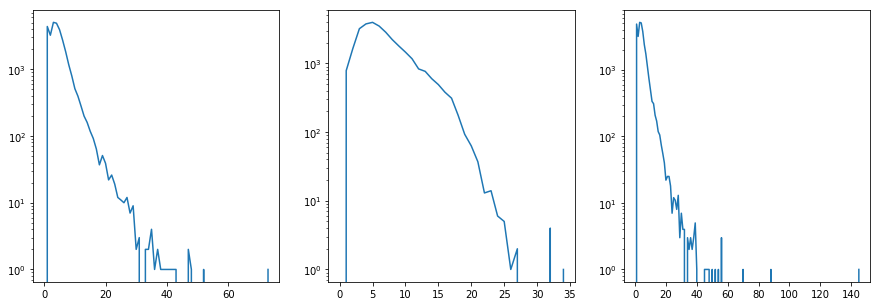

In [6]:
plt.figure(figsize=(15,5))
h = [defaultdict(int), defaultdict(int), defaultdict(int)]

for i, tur in enumerate(Xtrain):
    for sen in tur:
        h[i][len(sen)] += 1
    l_count = [h[i][x] for x in range(max_len[i] + 1)]
    plt.subplot(1,3,i + 1)
    plt.plot(range(max_len[i] + 1), l_count)
    plt.yscale('log')
    
max_len = [40, 34, 40]

- replace words by there ids of the embeddings and add padding

In [7]:
count_unk = 0
known = 0
for i in range(len(Xtrain)):
    for j in range(len(Xtrain[i])):
        for k in range(len(Xtrain[i][j])):
            if Xtrain[i][j][k] not in wv_data.keys():
                Xtrain[i][j][k] = wv_id['<unk>']
                count_unk += 1
            else:
                Xtrain[i][j][k] = wv_id[Xtrain[i][j][k]]
                known += 1
        Xtrain[i][j] = Xtrain[i][j][:max_len[i]]
        Xtrain[i][j] += [wv_id['<pad>']] * (max_len[i] - len(Xtrain[i][j]))
    Xtrain[i] = np.array(Xtrain[i])
print(Xtrain[0].shape)

print(count_unk, '/', count_unk + known)


count_unk = 0
known = 0
for i in range(len(Xtest)):
    for j in range(len(Xtest[i])):
        for k in range(len(Xtest[i][j])):
            if Xtest[i][j][k] not in wv_data.keys():
                Xtest[i][j][k] = wv_id['<unk>']
                count_unk += 1
            else:
                Xtest[i][j][k] = wv_id[Xtest[i][j][k]]
                known += 1
        Xtest[i][j] = Xtest[i][j][:max_len[i]]
        Xtest[i][j] += [wv_id['<pad>']] * (max_len[i] - len(Xtest[i][j]))
    Xtest[i] = np.array(Xtest[i])
print(Xtest[0].shape)
print(count_unk, '/', count_unk + known)


(30160, 40)
2265 / 483015
(2755, 40)
210 / 42792


In [8]:
X_train = Xtrain
y_train = Ytrain
X_test = Xtest
y_test = Ytest

# Deep Learning

In [9]:
import matplotlib
def generate_plot(H, nb_epoch):
    print("Generating plots...")
    sys.stdout.flush()
    matplotlib.use("Agg")
    matplotlib.pyplot.style.use("ggplot")
    matplotlib.pyplot.figure()
    N = nb_epoch
    matplotlib.pyplot.plot(np.arange(0, N), H.history["loss"], label="train_loss")
    matplotlib.pyplot.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
    matplotlib.pyplot.title("Training Loss on diabetic retinopathy detection")
    matplotlib.pyplot.xlabel("Epoch #")
    matplotlib.pyplot.ylabel("Loss")
    matplotlib.pyplot.legend(loc="lower left")

    matplotlib.pyplot.figure()
    matplotlib.pyplot.plot(np.arange(0, N), H.history["acc"], label="train_acc")
    matplotlib.pyplot.plot(np.arange(0, N), H.history["val_acc"], label="val_acc")
    matplotlib.pyplot.title("Training Accuracy on diabetic retinopathy detection")
    matplotlib.pyplot.xlabel("Epoch #")
    matplotlib.pyplot.ylabel("Accuracy")
    matplotlib.pyplot.legend(loc="lower left")

In [10]:
tmp_train = np.asarray(Ytrain).argmax(axis=-1)
unique, counts = np.unique(tmp_train, return_counts=True)
dict(zip(unique, counts))

{0: 14948, 1: 5506, 2: 5463, 3: 4243}

In [11]:
def get_RNN(unit=LSTM, cells=64, bi=False, return_sequences=True, dropout_U=0.,
            consume_less='cpu', l2_reg=0):
    rnn = unit(cells, return_sequences=return_sequences,
               consume_less=consume_less, dropout_U=dropout_U,
               W_regularizer=l2(l2_reg))
    if bi:
        return Bidirectional(rnn)
    else:
        return rnn

In [12]:
label2emotion = {0:"others", 1:"angry", 2: "sad", 3:"happy"}
emotion2label = {0: 'others', 1: 'angry', 2: 'sad', 3: 'happy'}
def getMetrics(predictions, ground, verbose=False):
    """Given predicted labels and the respective ground truth labels, display some metrics
    Input: shape [# of samples, NUM_CLASSES]
        predictions : Model output. Every row has 4 decimal values, with the highest belonging to the predicted class
        ground : Ground truth labels, converted to one-hot encodings. A sample belonging to Happy class will be [0, 1, 0, 0]
    Output:
        accuracy : Average accuracy
        microPrecision : Precision calculated on a micro level. Ref - https://datascience.stackexchange.com/questions/15989/micro-average-vs-macro-average-performance-in-a-multiclass-classification-settin/16001
        microRecall : Recall calculated on a micro level
        microF1 : Harmonic mean of microPrecision and microRecall. Higher value implies better classification  
    """
    # [0.1, 0.3 , 0.2, 0.1] -> [0, 1, 0, 0]
    discretePredictions = to_categorical(predictions.argmax(axis=1))
    
    truePositives = np.sum(discretePredictions*ground, axis=0)
    falsePositives = np.sum(np.clip(discretePredictions - ground, 0, 1), axis=0)
    falseNegatives = np.sum(np.clip(ground-discretePredictions, 0, 1), axis=0)
    
    if verbose:
        print("True Positives per class : ", truePositives)
        print("False Positives per class : ", falsePositives)
        print("False Negatives per class : ", falseNegatives)
    
    # ------------- Macro level calculation ---------------
    macroPrecision = 0
    macroRecall = 0
    # We ignore the "Others" class during the calculation of Precision, Recall and F1
    for c in range(1, predictions.shape[1]):
        precision = truePositives[c] / (truePositives[c] + falsePositives[c])
        macroPrecision += precision
        recall = truePositives[c] / (truePositives[c] + falseNegatives[c])
        macroRecall += recall
        f1 = ( 2 * recall * precision ) / (precision + recall) if (precision+recall) > 0 else 0
        if verbose:
            print("Class %s : Precision : %.3f, Recall : %.3f, F1 : %.3f" % (label2emotion[c], precision, recall, f1))
    
    macroPrecision /= 3
    macroRecall /= 3
    macroF1 = (2 * macroRecall * macroPrecision ) / (macroPrecision + macroRecall) if (macroPrecision+macroRecall) > 0 else 0
    if verbose:
        print("Ignoring the Others class, Macro Precision : %.4f, Macro Recall : %.4f, Macro F1 : %.4f" % (macroPrecision, macroRecall, macroF1))   
    
    # ------------- Micro level calculation ---------------
    truePositives = truePositives[1:].sum()
    falsePositives = falsePositives[1:].sum()
    falseNegatives = falseNegatives[1:].sum()    
    
    if verbose:
        print("Ignoring the Others class, Micro TP : %d, FP : %d, FN : %d" % (truePositives, falsePositives, falseNegatives))
    
    microPrecision = truePositives / (truePositives + falsePositives)
    microRecall = truePositives / (truePositives + falseNegatives)
    
    microF1 = ( 2 * microRecall * microPrecision ) / (microPrecision + microRecall) if (microPrecision+microRecall) > 0 else 0
    # -----------------------------------------------------
    
    predictions = predictions.argmax(axis=1)
    ground = ground.argmax(axis=1)
    accuracy = np.mean(predictions==ground)
    
    if verbose:
        print("Accuracy : %.4f, Micro Precision : %.4f, Micro Recall : %.4f, Micro F1 : %.4f" % (accuracy, microPrecision, microRecall, microF1))
    return accuracy, microPrecision, microRecall, microF1

In [13]:
dic = {'others': 0, 'angry': 1, 'sad': 2, 'happy': 3}

metrics = {
    "f1_pn": (lambda y_test, y_pred:
              f1_score(y_test, y_pred, average='micro',
                       labels=[dic['happy'],
                               dic['sad'],
                               dic['angry'],
                               dic['others']])),
    "M_recall": (
        lambda y_test, y_pred: recall_score(y_test, y_pred, average='micro')),
    "M_precision": (
        lambda y_test, y_pred: precision_score(y_test, y_pred,
                                               average='micro')),
    "pearson": (
        lambda y_test, y_pred: scipy.stats.pearsonr(y_test, y_pred)[0]),
    "f1": (
        lambda y_test, y_pred: getMetrics(to_categorical(y_test), to_categorical(y_pred))[3])
}


plotting = PlottingCallback(grid_ranges=(0.5, 0.75), height=5,
                            benchmarks={"SE17": 0.681})


checkpointer = ModelCheckpoint(filepath='/mnt/dd/modelv8.{epoch:02d}-{val_loss:.2f}.hdf5',
                               monitor='val.macro_recall', mode="max",
                               verbose=1, save_best_only=False)
#_callbacks.append(checkpointer)

_datasets = {}
_datasets["1-train"] = (X_train, y_train)
_datasets["2-val"] = (X_test, y_test)
_datasets["3-test"] = (Xtest, Ytest)
metrics_callback = MetricsCallback(datasets=_datasets, metrics=metrics)
    
    
_callbacks = [metrics_callback, checkpointer]

In [14]:

#embeddings = np.array(list(wv_data.values()))
classes=4
max_length=max_len
unit=LSTM #LSTM / GRU
layers=2
cells=64 #150
final_size = 100
bidirectional=True
attention="simple"
noise=0.2
final_layer=False
dropout_final=0.2 #0.4
dropout_attention=0.4
dropout_words=0.2
dropout_rnn=0.2
dropout_rnn_U=0.2
clipnorm=1
lr=0.01 #0.001
loss_l2=0.001 #0.0001

In [16]:
#shared_RNN = get_RNN(unit, cells, bi=bidirectional, return_sequences='context',
#                         dropout_U=dropout_rnn_U)


input_turn0 = Input(shape=[max_len[0]], dtype='int32')
input_turn1 = Input(shape=[max_len[1]], dtype='int32')
input_turn2 = Input(shape=[max_len[2]], dtype='int32')


# Embeddings
turn0_emb = Embedding(
    input_dim=embeddings.shape[0],
    output_dim=embeddings.shape[1],
    input_length=max_len[0],
    trainable=True,
    mask_zero=True,
    weights=[embeddings]
)(input_turn0)

turn1_emb = Embedding(
    input_dim=embeddings.shape[0],
    output_dim=embeddings.shape[1],
    input_length=max_len[1],
    trainable=True,
    mask_zero=True,
    weights=[embeddings]
)(input_turn1)

turn2_emb = Embedding(
    input_dim=embeddings.shape[0],
    output_dim=embeddings.shape[1],
    input_length=max_len[2],
    trainable=True,
    mask_zero=True,
    weights=[embeddings]
)(input_turn2)


# Recurrent NN
h_turn0 = get_RNN(unit, cells, bi=bidirectional, return_sequences='context',
                         dropout_U=dropout_rnn_U)(turn0_emb)
h_turn0 = Dropout(dropout_rnn_U)(h_turn0)


h_turn1 = get_RNN(unit, cells, bi=bidirectional, return_sequences='context',
                         dropout_U=dropout_rnn_U)(turn1_emb)
h_turn1 = Dropout(dropout_rnn_U)(h_turn1)


h_turn2 = get_RNN(unit, cells, bi=bidirectional, return_sequences='context',
                         dropout_U=dropout_rnn_U)(turn2_emb)
h_turn2 = Dropout(dropout_rnn_U)(h_turn2)


print(h_turn0.shape, h_turn1.shape, h_turn2.shape)

representation = concatenate([h_turn0, h_turn1, h_turn2], axis=1)
representation = AttentionWithContext()(representation)
representation = Dense(64, activation='linear')(representation)
representation = Dropout(dropout_final)(representation)

representation = Dense(32, activation='linear')(representation)
representation = Dropout(dropout_final)(representation)


probabilities = Dense(classes, activation="softmax", activity_regularizer=l2(loss_l2))(representation)

model = Model(input=[input_turn0, input_turn1, input_turn2], output=probabilities)

model.compile(optimizer=Adam(clipnorm=clipnorm, lr=lr),
              loss='categorical_crossentropy', metrics=['mae', 'accuracy'])

model.summary()

/home/arthur/anaconda3/envs/taln/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(64, return_sequences="context", kernel_regularizer=<keras.reg..., recurrent_dropout=0.2, implementation=0)`
  """
/home/arthur/anaconda3/envs/taln/lib/python3.6/site-packages/keras/layers/recurrent.py:1977: UserWarning: `implementation=0` has been deprecated, and now defaults to `implementation=1`.Please update your layer call.
  warnings.warn('`implementation=0` has been deprecated, '
/home/arthur/anaconda3/envs/taln/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(64, return_sequences="context", kernel_regularizer=<keras.reg..., recurrent_dropout=0.2, implementation=0)`
  """
/home/arthur/anaconda3/envs/taln/lib/python3.6/site-packages/keras/layers/recurrent.py:1977: UserWarning: `implementation=0` has been deprecated, and now defaults to `implementation=1`.Please update 

(?, ?, 128) (?, ?, 128) (?, ?, 128)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 40)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 34)           0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 40)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 40, 100)      65812500    input_1[0][0]                    
_________________________________________________________________________

/home/arthur/anaconda3/envs/taln/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("de...)`


In [17]:
plot_model(model, to_file='model.png')

![model](model.png)

In [18]:
nb_epoch = 7
H = model.fit(X_train, y_train, epochs=nb_epoch, batch_size=100, validation_data=(X_test, y_test),
              callbacks=_callbacks);

Train on 30160 samples, validate on 2755 samples
Epoch 1/7
30100/30160 [============================>.] - ETA: 0s - loss: 0.6401 - mean_absolute_error: 0.1479 - acc: 0.8109         M_precision  M_recall        f1     f1_pn   pearson
1-train     0.890915  0.890915  0.875819  0.890915  0.793440
2-val       0.889655  0.889655  0.669421  0.889655  0.641413
3-test      0.889655  0.889655  0.669421  0.889655  0.641413

Epoch 00001: saving model to /mnt/dd/modelv8.01-0.46.hdf5
30160/30160 [==============================] - 267s 9ms/step - loss: 0.6398 - mean_absolute_error: 0.1478 - acc: 0.8110 - val_loss: 0.4607 - val_mean_absolute_error: 0.0984 - val_acc: 0.8897 - 1-train.f1_pn: 0.8909 - 1-train.M_recall: 0.8909 - 1-train.M_precision: 0.8909 - 1-train.pearson: 0.7934 - 1-train.f1: 0.8758 - 2-val.f1_pn: 0.8897 - 2-val.M_recall: 0.8897 - 2-val.M_precision: 0.8897 - 2-val.pearson: 0.6414 - 2-val.f1: 0.6694 - 3-test.f1_pn: 0.8897 - 3-test.M_recall: 0.8897 - 3-test.M_precision: 0.8897 - 3-test.p

In [ ]:
generate_plot(H, nb_epoch)

In [15]:
loaded_model = None
with CustomObjectScope({'Attention': Attention, 'AttentionWithContext': AttentionWithContext}):
    loaded_model = load_model('/mnt/dd/modelv6.04-0.47.hdf5')

In [ ]:
loaded_model.summary()

In [16]:
res = loaded_model.predict(Xtest)
res.shape

(2755, 4)

In [23]:
from keras.utils import np_utils

dic = {'others': 0, 'angry': 1, 'sad': 2, 'happy': 3}

getMetrics(Ytest, res, verbose=True)

f1_macro: 0.760732223339039
M_recall: 0.9012704174228675
M_precision: 0.9012704174228675
pearson: 0.6701673753893513
True Positives per class :  [2111.86130146  121.84337423   91.28779425  103.74091497]
False Positives per class :  [226.13869854  28.15662577  33.71220575  38.25908503]
False Negatives per class :  [ 82.56849863 114.30691099  46.9312464   82.45996037]
Class angry : Precision : 0.812, Recall : 0.516, F1 : 0.631
Class sad : Precision : 0.730, Recall : 0.660, F1 : 0.694
Class happy : Precision : 0.731, Recall : 0.557, F1 : 0.632
Ignoring the Others class, Macro Precision : 0.7577, Macro Recall : 0.5779, Macro F1 : 0.6557
Ignoring the Others class, Micro TP : 316, FP : 100, FN : 243
Accuracy : 0.9013, Micro Precision : 0.7599, Micro Recall : 0.5653, Micro F1 : 0.6483
getMetrics: (0.9012704174228675, 0.7598850922246942, 0.5652674415589133, 0.6482850706011686)


In [ ]:
dic_inv = {0: 'others', 1: 'angry', 2: 'sad', 3: 'happy'}
res_txt = [dic_inv[np.argmax(r)] for r in res]
df = pd.read_csv('../data/test.txt', sep='\t', index_col=0)
df['label'] = res_txt
df.head()
df.to_csv('submit1.txt', sep='\t')